# Predicting Rating Levels Associated with User Reviews from Amazon Reviews

Overview of the Process 
This study is to predict rating levels associated with user reviews from Amazon reviews. For the prediction through machine learning, a total of 518,430 labeled review were loaded from the Kaggle site and cleaned using the Natural Language Toolkit and regular expression modules. The cleaned data were vectorized using TF-IDF method and vectorized data were used to train and validate a total of 8 machine learning models: Multinomial Naïve Bayes, Extreme Gradient Boosting, Support Vector machine, Decision Tree, Random Forest, Multi-layer Perceptron, K-nearest neighbors, and Long short-term memory. The performance of the trained models was evaluated by four metrics (accuracy, precision, recall and F1), and the best performing model was selected to predict the rating level of the test data which included 5,000 reviews with no rating.  Additional data analyses were conducted to describe training data and summarize the results.




# Data for Model Building and Validation

In [1]:
import wget

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re, string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ktrain
from ktrain import text
import cleantext
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import xgboost as xgb 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.utils.deprecation import _raise_dep_warning_if_not_pytest

import numpy as np


In [3]:
wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py')

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

100% [..............................................................................] 10246 / 10246

In [4]:
import wget

url ="https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
wget.download(url)

100% [............................................................................] 607343 / 607343

'nlp_getting_started (5).zip'

In [5]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys
# Unzip data
unzip_data("nlp_getting_started.zip")

In [6]:
#data read

import pandas as pd
train_df = pd.read_csv("C:/Users/jelee/MIS/foods_training.csv",  sep="|", encoding = "ISO-8859-1")
train_df.head()

,reviewID,productID,userId,profileName,helpfulness,score_level,time,summary,text
0,58757,B005P0NA7U,A3DWYS6US3PR2M,"Liz,H ""Ann""",0/0,high,1310688000,great ! !,i used this product on my face along with alba...
1,467637,B007PEQKXA,A2LXGRL0OZJN7H,Larry L. Hassenpflug II,1/1,high,1291852800,Very impressed,I ordered a one pound package for my Dad this ...
2,70899,B00451U9Q0,A2P6UN9OMVB2NF,Larry Harrington,1/2,high,1321488000,Fellow ship,"I am the setup person in my church, for mornin..."
3,500052,B001CU0N4A,A2U58C5IL0TCN4,S. Rose,5/8,medium,1297900800,Tasty but why dairy?,Looking for low carb snacks without dairy or e...
4,451159,B008JELG8E,AYZQ9TOYTTH0L,tyreman,0/0,high,1350691200,Tasty,I am a long time diabetic and always looking f...


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518430 entries, 0 to 518429
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reviewID     518430 non-null  int64 
 1   productID    518430 non-null  object
 2   userId       518430 non-null  object
 3   profileName  518415 non-null  object
 4   helpfulness  518430 non-null  object
 5   score_level  518430 non-null  object
 6   time         518430 non-null  int64 
 7   summary      518408 non-null  object
 8   text         518430 non-null  object
dtypes: int64(2), object(7)
memory usage: 35.6+ MB


In [4]:
train_df.isna().sum()

reviewID        0
productID       0
userId          0
profileName    15
helpfulness     0
score_level     0
time            0
summary        22
text            0
dtype: int64

In [5]:
train_df["score_level"].value_counts()

high      404594
low        74942
medium     38894
Name: score_level, dtype: int64

In [7]:
##Data cleaning


import re, string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # miniscule
    text = text.lower()
    
    #remove emoji
    text = text.encode("ascii", "ignore").decode()
    
    # removing usernames
    text = re.sub('@[^\s]+', '', text)

    # removing links
    text = re.sub('((https?://[^\s]+)|(www\.[^\s]+))','',text)
    
        # removing rt
    text = re.sub('rt','',text)
    
    # removing punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    
    # tokenization
    tokens = word_tokenize(text)
   
    # suppression of stop words and lemmatization
    wordLemm = WordNetLemmatizer()
    final_words = []
    for token in tokens:
      # suppression of stop words
      if token not in stop_words and len(token) > 1:
        lemm = wordLemm.lemmatize(token)
        final_words.append(lemm)
    return ' '.join(final_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jelee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jelee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jelee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
train_df['cleantext'] = train_df.text.apply(clean_text)

In [9]:
train_df=train_df.dropna(subset=["score_level"])
train_df

,reviewID,productID,userId,profileName,helpfulness,score_level,time,summary,text,cleantext
0,58757,B005P0NA7U,A3DWYS6US3PR2M,"Liz,H ""Ann""",0/0,high,1310688000,great ! !,i used this product on my face along with alba...,used product face along alba papaya facial mas...
1,467637,B007PEQKXA,A2LXGRL0OZJN7H,Larry L. Hassenpflug II,1/1,high,1291852800,Very impressed,I ordered a one pound package for my Dad this ...,ordered one pound package dad christmas cant r...
2,70899,B00451U9Q0,A2P6UN9OMVB2NF,Larry Harrington,1/2,high,1321488000,Fellow ship,"I am the setup person in my church, for mornin...",setup person church morning coffee thing churc...
3,500052,B001CU0N4A,A2U58C5IL0TCN4,S. Rose,5/8,medium,1297900800,Tasty but why dairy?,Looking for low carb snacks without dairy or e...,looking low carb snack without dairy egg aller...
4,451159,B008JELG8E,AYZQ9TOYTTH0L,tyreman,0/0,high,1350691200,Tasty,I am a long time diabetic and always looking f...,long time diabetic always looking sweet treat ...
...,...,...,...,...,...,...,...,...,...,...
518425,469934,B001E5E3XU,AEYYJWN7ZWN0Z,Mary Alice Mcconnell,3/3,high,1261785600,Coleman's Mustard - when you want the very best!,"This is the best mustard, we always had it gro...",best mustard always growing ireland hard find ...
518426,448858,B002ZOG2B0,A2D4VH1GILGTDT,Swamp Wizard,4/4,high,1317513600,Swamp Wizard,Hazelnut 8 O'clock coffee is very fresh and ta...,hazelnut oclock coffee fresh tasty price great...
518427,43039,B000Z95UME,A397TLU6QL8S9Q,"Donna Tokunaga ""Moonrise""",0/0,high,1284768000,Best tasting Earl Grey tea,I first had this tea in a small restaurant in ...,first tea small restaurant ashland marveled fl...
518428,88158,B0030VBQOK,A1WV31UF6HVC9W,JMom,0/0,high,1334016000,Daughter loves them,My daughter is 22 months old and can finish of...,daughter 22 month old finish pouch le 30 secon...


In [68]:
# text length by score level
train_df['len']=train_df['cleantext'].str.len()
print(train_df.groupby('score_level')['len'].mean())
print(train_df.groupby('score_level')['len'].std())

score_level
high      254.810440
low       292.167356
medium    314.116676
Name: len, dtype: float64
score_level
high      266.385073
low       309.077329
medium    320.556312
Name: len, dtype: float64


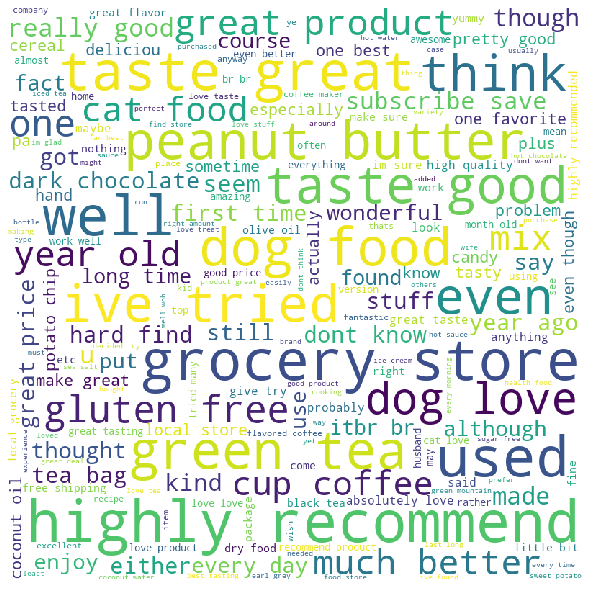

In [38]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

comment_words0 = ''


for val in train_df[(train_df['score_level']=='high')].cleantext:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words0 += " ".join(tokens)+" "
 
wordcloud0 = WordCloud(width = 800, height = 800,
                background_color ='white',
                max_words=200,
                min_font_size = 10).generate(comment_words0)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud0, interpolation="nearest") #, interpolation="nearest",
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["cleantext"].to_numpy(),
                                                                            train_df["score_level"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [11]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(466587, 466587, 51843, 51843)

In [33]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [34]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [14]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

# Model0: MultinomialNB

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array(['high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high'], dtype='<U6')

In [18]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [23]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.28360627278514,
 'precision': 0.8205062271380987,
 'recall': 0.7928360627278513,
 'f1': 0.712309221853785}

# Model_0_1:XGBoost

In [24]:
import xgboost as xgb 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0_1 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", xgb.XGBClassifier()) # model the text
])

# Fit the pipeline to the training data
model_0_1.fit(train_sentences, train_labels)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [25]:
# Make predictions
baseline01_preds = model_0_1.predict(val_sentences)
baseline01_preds[:20]

array(['high', 'low', 'low', 'high', 'high', 'high', 'low', 'high', 'low',
       'high', 'low', 'high', 'high', 'high', 'high', 'high', 'high',
       'low', 'high', 'high'], dtype=object)

In [26]:
# Get baseline results
baseline01_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline01_preds)
baseline01_results

{'accuracy': 85.7589259880794,
 'precision': 0.8452190808906804,
 'recall': 0.8575892598807939,
 'f1': 0.831661910860944}

# SVM

In [43]:
from sklearn import svm

In [45]:
# Create tokenization and modelling pipeline
model_0_s = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", svm.SVC()) # model the text
])

# Fit the pipeline to the training data
model_0_s.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', SVC(gamma=0.001))])

In [46]:
# Make predictions
baseline0s_preds = model_0_s.predict(val_sentences)
baseline0s_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline0s_preds)
baseline0s_results

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 78.0548965144764,
 'precision': 0.6092566869885621,
 'recall': 0.780548965144764,
 'f1': 0.6843470175941245}

In [ ]:
baseline0s_preds[:20]

# KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
# Create tokenization and modelling pipeline
model_0k = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", KNeighborsClassifier(n_neighbors=1)) # model the text
])

# Fit the pipeline to the training data
model_0k.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=1))])

In [52]:
# Make predictions
baseline0k_preds = model_0k.predict(val_sentences)
baseline0k_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline0k_preds)
baseline0k_results

{'accuracy': 86.17749744420655,
 'precision': 0.8626465295482388,
 'recall': 0.8617749744420655,
 'f1': 0.8420966752383667}

# Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
# Create tokenization and modelling pipeline
model_0d = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", DecisionTreeClassifier()) # model the text
])

# Fit the pipeline to the training data
model_0d.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier())])

In [55]:
# Make predictions
baseline0d_preds = model_0d.predict(val_sentences)
baseline0d_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline0d_preds)
baseline0d_results

{'accuracy': 85.5274579017418,
 'precision': 0.8511510595762644,
 'recall': 0.855274579017418,
 'f1': 0.8529997873828398}

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Create tokenization and modelling pipeline
model_0r = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", RandomForestClassifier(n_estimators=600)) # model the text
])

# Fit the pipeline to the training data
model_0r.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_estimators=600))])

In [ ]:
# Make predictions
baseline0r_preds = model_0r.predict(val_sentences)

In [25]:
baseline0r_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline0r_preds)
baseline0r_results

{'accuracy': 88.20477210038,
 'precision': 0.8959965535937514,
 'recall': 0.8820477210037999,
 'f1': 0.8642107711178713}

In [26]:
baseline0r_preds[:20]

array(['high', 'low', 'low', 'high', 'high', 'high', 'low', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high'], dtype=object)

In [29]:
# Make predictions
baseline02_preds = model_0_2.predict(val_sentences)
baseline02_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline02_preds)
baseline02_results

{'accuracy': 41.32091121269988,
 'precision': 0.7251044346692632,
 'recall': 0.41320911212699885,
 'f1': 0.4638410410357201}

# MLPClassifier

In [15]:
from sklearn.neural_network import MLPClassifier

In [16]:
# Create tokenization and modelling pipeline
model_0_3 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MLPClassifier(max_iter=100, random_state=42)) # model the text
])

# Fit the pipeline to the training data
model_0_3.fit(train_sentences, train_labels)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', MLPClassifier(max_iter=100, random_state=42))])

In [19]:
# Make predictions
baseline03_preds = model_0_3.predict(val_sentences)
baseline03_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline03_preds)
baseline03_results

{'accuracy': 90.27834037382097,
 'precision': 0.8982642243476165,
 'recall': 0.9027834037382096,
 'f1': 0.9000677663568981}

# Feed-forward neural network (dense model)

In [29]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [30]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_labels)
encoded_Y = encoder.transform(train_labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(val_labels)
encoded_val = encoder.transform(val_labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_val = np_utils.to_categorical(encoded_val)


In [32]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [37]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(3, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [38]:
# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,280,387
Trainable params: 1,280,387
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              dummy_y,
                              epochs=5,
                              validation_data=(val_sentences, dummy_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220429-095437
Epoch 1/5
14581/14581 [==============================] - 273s 18ms/step - loss: 0.4790 - accuracy: 0.8247 - val_loss: 0.4578 - val_accuracy: 0.8331
Epoch 2/5
14581/14581 [==============================] - 255s 18ms/step - loss: 0.4503 - accuracy: 0.8342 - val_loss: 0.4548 - val_accuracy: 0.8362
Epoch 3/5
14581/14581 [==============================] - 279s 19ms/step - loss: 0.4437 - accuracy: 0.8365 - val_loss: 0.4540 - val_accuracy: 0.8359
Epoch 4/5
14581/14581 [==============================] - 319s 22ms/step - loss: 0.4405 - accuracy: 0.8376 - val_loss: 0.4537 - val_accuracy: 0.8365
Epoch 5/5
14581/14581 [==============================] - 257s 18ms/step - loss: 0.4383 - accuracy: 0.8384 - val_loss: 0.4563 - val_accuracy: 0.8361


In [41]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=dummy_val, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.4729085893949,
 'precision': 0.8295304142498574,
 'recall': 0.814729085893949,
 'f1': 0.8012203224507465}

# LSTM

In [59]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(3, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [60]:
# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              dummy_y,
                              epochs=5,
                              validation_data=(val_sentences, dummy_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220429-124437
Epoch 1/5
14581/14581 [==============================] - 662s 45ms/step - loss: 0.4612 - accuracy: 0.8331 - val_loss: 0.4240 - val_accuracy: 0.8466
Epoch 2/5
14581/14581 [==============================] - 623s 43ms/step - loss: 0.3863 - accuracy: 0.8626 - val_loss: 0.3940 - val_accuracy: 0.8636
Epoch 3/5
14581/14581 [==============================] - 619s 42ms/step - loss: 0.3318 - accuracy: 0.8842 - val_loss: 0.3797 - val_accuracy: 0.8691
Epoch 4/5
14581/14581 [==============================] - 670s 46ms/step - loss: 0.2847 - accuracy: 0.9019 - val_loss: 0.3832 - val_accuracy: 0.8722
Epoch 5/5
14581/14581 [==============================] - 563s 39ms/step - loss: 0.2428 - accuracy: 0.9173 - val_loss: 0.3979 - val_accuracy: 0.8738


In [62]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(y_true=dummy_val,
                                    y_pred=model_2_preds)

model_2_results 

{'accuracy': 86.21800435931563,
 'precision': 0.8750269073218534,
 'recall': 0.8621800435931563,
 'f1': 0.8622291147504864}

# Predict test data with the best model
MLP

In [20]:
df=pd.read_csv("C:/Users/jelee/MIS/foods_testing.csv",  sep="|", encoding = "ISO-8859-1")
df.head()

,reviewID,productID,userId,profileName,helpfulness,time,summary,text
0,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,20,B001GVISJM,A1WO0KGLPR5PV6,mom2emma,0/0,1313452800,Always fresh,My husband is a Twizzlers addict. We've bough...
2,49,B001EO5QW8,A276999Y6VRSCQ,JMay,0/1,1334016000,Same stuff,This is the same stuff you can buy at the big ...
3,50,B001EO5QW8,A108P30XVUFKXY,Roberto A,0/7,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
4,78,B004X2KR36,A2AB7M9UCNBVN7,sharonh4,0/0,1346976000,Order only in cold weather,"The taste was great, but the berries had melte..."


In [21]:
#Clean the text

df['cleantext'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,reviewID,productID,userId,profileName,helpfulness,time,summary,text,cleantext
0,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,20,B001GVISJM,A1WO0KGLPR5PV6,mom2emma,0/0,1313452800,Always fresh,My husband is a Twizzlers addict. We've bough...,husband twizzlers addict weve bought many time...
2,49,B001EO5QW8,A276999Y6VRSCQ,JMay,0/1,1334016000,Same stuff,This is the same stuff you can buy at the big ...,stuff buy big box store nothing healthy carbs ...
3,50,B001EO5QW8,A108P30XVUFKXY,Roberto A,0/7,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",oatmeal good mushy soft dont like quaker oat w...
4,78,B004X2KR36,A2AB7M9UCNBVN7,sharonh4,0/0,1346976000,Order only in cold weather,"The taste was great, but the berries had melte...",taste great berry melted may order winter orde...


In [25]:
ct=np.asarray(df['cleantext'])

model_0_3_pred_probs = model_0_3.predict(ct)
#model_0_3_preds = tf.squeeze(tf.round(model_0_3_pred_probs)) # squeeze removes single dimensions

#model_0_3_pred_probs[:20]


array(['high', 'high', 'low', 'low', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'medium', 'high', 'low',
       'high', 'medium', 'medium', 'high'], dtype='<U6')

In [28]:
len(model_0_3_pred_probs)

5000

In [29]:
df1=pd.DataFrame(model_0_3_pred_probs)
df1.columns=['score_level']

frames=[df,df1 ]
df=pd.concat(frames, axis=1)
display(df.head())

,reviewID,productID,userId,profileName,helpfulness,time,summary,text,cleantext,score_level
0,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,high
1,20,B001GVISJM,A1WO0KGLPR5PV6,mom2emma,0/0,1313452800,Always fresh,My husband is a Twizzlers addict. We've bough...,husband twizzlers addict weve bought many time...,high
2,49,B001EO5QW8,A276999Y6VRSCQ,JMay,0/1,1334016000,Same stuff,This is the same stuff you can buy at the big ...,stuff buy big box store nothing healthy carbs ...,low
3,50,B001EO5QW8,A108P30XVUFKXY,Roberto A,0/7,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",oatmeal good mushy soft dont like quaker oat w...,low
4,78,B004X2KR36,A2AB7M9UCNBVN7,sharonh4,0/0,1346976000,Order only in cold weather,"The taste was great, but the berries had melte...",taste great berry melted may order winter orde...,high


In [30]:
df.score_level.value_counts()

high      3935
low        734
medium     331
Name: score_level, dtype: int64

In [39]:
from textblob import TextBlob

def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

df['sentiment'] = df['cleantext'].apply(sentiment_calc)

In [40]:
df

,reviewID,productID,userId,profileName,helpfulness,time,summary,text,cleantext,score_level,sentiment
0,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,high,0.425000
1,20,B001GVISJM,A1WO0KGLPR5PV6,mom2emma,0/0,1313452800,Always fresh,My husband is a Twizzlers addict. We've bough...,husband twizzlers addict weve bought many time...,high,0.400000
2,49,B001EO5QW8,A276999Y6VRSCQ,JMay,0/1,1334016000,Same stuff,This is the same stuff you can buy at the big ...,stuff buy big box store nothing healthy carbs ...,low,0.066667
3,50,B001EO5QW8,A108P30XVUFKXY,Roberto A,0/7,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",oatmeal good mushy soft dont like quaker oat w...,low,0.400000
4,78,B004X2KR36,A2AB7M9UCNBVN7,sharonh4,0/0,1346976000,Order only in cold weather,"The taste was great, but the berries had melte...",taste great berry melted may order winter orde...,high,0.200000
...,...,...,...,...,...,...,...,...,...,...,...
4995,55839,B000GZY8FC,A2CDFOO1GZ0VTO,"Rita ""Rita""",4/4,1268006400,Wonderful Poppyseed Cakes,This filling is wonderful and a good value ove...,filling wonderful good value buying grocery st...,high,0.675000
4996,55848,B000GZY8FC,AYS9AV8EVGOSX,"Hella Slomnicki ""baker""",0/0,1234396800,Solo Poppyseed Filling,I have been using the poppyseed filling for ye...,using poppyseed filling year pleased get deliv...,high,0.500000
4997,55851,B000GZY8FC,A1IX5D2OQU62UK,"Olya ""OK.""",2/4,1241136000,Poppy Seed Pie Filling,Too sweet for my taste... I had to add egg yol...,sweet taste add egg yolk dry poppy seed milk m...,high,0.211111
4998,55894,B002Y2QTNO,AO5G2L4IS9GRQ,Preemie Mommy,0/0,1326240000,Not good for strong coffee lovers,"I like my coffee strong, but if you use a heap...",like coffee strong use heaping scoop per two c...,low,0.020833


In [41]:


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_calc(text):
    try:
        return analyzer.polarity_scores(text)['compound']
    
    except:
        return None

df['vader'] = df['text'].apply(vader_calc)

df

,reviewID,productID,userId,profileName,helpfulness,time,summary,text,cleantext,score_level,sentiment,vader
0,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,high,0.425000,0.9441
1,20,B001GVISJM,A1WO0KGLPR5PV6,mom2emma,0/0,1313452800,Always fresh,My husband is a Twizzlers addict. We've bough...,husband twizzlers addict weve bought many time...,high,0.400000,0.6249
2,49,B001EO5QW8,A276999Y6VRSCQ,JMay,0/1,1334016000,Same stuff,This is the same stuff you can buy at the big ...,stuff buy big box store nothing healthy carbs ...,low,0.066667,0.2363
3,50,B001EO5QW8,A108P30XVUFKXY,Roberto A,0/7,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",oatmeal good mushy soft dont like quaker oat w...,low,0.400000,-0.5448
4,78,B004X2KR36,A2AB7M9UCNBVN7,sharonh4,0/0,1346976000,Order only in cold weather,"The taste was great, but the berries had melte...",taste great berry melted may order winter orde...,high,0.200000,0.7814
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55839,B000GZY8FC,A2CDFOO1GZ0VTO,"Rita ""Rita""",4/4,1268006400,Wonderful Poppyseed Cakes,This filling is wonderful and a good value ove...,filling wonderful good value buying grocery st...,high,0.675000,0.9184
4996,55848,B000GZY8FC,AYS9AV8EVGOSX,"Hella Slomnicki ""baker""",0/0,1234396800,Solo Poppyseed Filling,I have been using the poppyseed filling for ye...,using poppyseed filling year pleased get deliv...,high,0.500000,0.4404
4997,55851,B000GZY8FC,A1IX5D2OQU62UK,"Olya ""OK.""",2/4,1241136000,Poppy Seed Pie Filling,Too sweet for my taste... I had to add egg yol...,sweet taste add egg yolk dry poppy seed milk m...,high,0.211111,0.6915
4998,55894,B002Y2QTNO,AO5G2L4IS9GRQ,Preemie Mommy,0/0,1326240000,Not good for strong coffee lovers,"I like my coffee strong, but if you use a heap...",like coffee strong use heaping scoop per two c...,low,0.020833,-0.9009


In [43]:
print(df.groupby('score_level')['sentiment'].mean())
print(df.groupby('score_level')['sentiment'].std())

score_level
high      0.297245
low       0.039027
medium    0.176921
Name: sentiment, dtype: float64
score_level
high      0.207697
low       0.240332
medium    0.169371
Name: sentiment, dtype: float64


In [44]:
print(df.groupby('score_level')['vader'].mean())
print(df.groupby('score_level')['vader'].std())

score_level
high      0.771778
low       0.100336
medium    0.524769
Name: vader, dtype: float64
score_level
high      0.324373
low       0.631709
medium    0.500528
Name: vader, dtype: float64


In [ ]:
#COnvert to csv data

df.to_csv('C:/Users/jelee/MIS/Amazon_submission.csv')